In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime as dt
import datetime
from datetime import timedelta  
import timeboard as tb # turnos 

# para tratar de poner espanol
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data
from matplotlib_venn import venn3
from matplotlib_venn import venn2, venn2_circles
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline


#otro graficador
import seaborn as sns

#stats

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/home/egidio/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# importar funciones locales

In [2]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())


['/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc']

# importo BD 

In [3]:
os.getcwd()

'/home/egidio/Dropbox/Trabajos científicos/SIDRA/Compiladores Jupyter/huelgas'

In [4]:
sidra = pd.read_pickle('./BDs/BD compiladas/sidra.pkl')
os.getcwd()
#sidra = pd.read_pickle('/home/egidio/Dropbox/Trabajos científicos/SIDRA/BD generadas/BD mar/sidra.pkl')

'/home/egidio/Dropbox/Trabajos científicos/SIDRA/Compiladores Jupyter/huelgas'

In [5]:
sidra.TS_ingreso.describe()

count                   14346
unique                   8097
top       2019-10-17 10:52:00
freq                        9
first     2019-10-16 00:00:00
last      2019-10-26 10:04:00
Name: TS_ingreso, dtype: object

### Población

desde una BD sacada del INE puedo tener la población de cada una de las comunas del territorio

In [6]:
poblacion = pd.read_csv('./BDs/censo2017_poblacion.csv')

In [7]:
poblacion.columns
poblacion[['NOM_COMUNA', 'TOTAL_VIVI' , 'TOTAL_PERS', 'Shape__Area']].head()

Index(['FID', 'REGION', 'PROVINCIA', 'COMUNA', 'NOM_REGION', 'NOM_PROVIN',
       'NOM_COMUNA', 'TOTAL_VIVI', 'PARTICULAR', 'COLECTIVAS', 'TOTAL_PERS',
       'HOMBRES', 'MUJERES', 'DENSIDAD', 'INDICE_MAS', 'INDICE_DEP',
       'IND_DEP_JU', 'IND_DEP_VE', 'Shape__Area', 'Shape__Length'],
      dtype='object')

,NOM_COMUNA,TOTAL_VIVI,TOTAL_PERS,Shape__Area
0,VALPARAÍSO,117196,296655,4.520715e+08
1,CASABLANCA,11606,26867,1.370067e+09
2,CONCÓN,20290,42152,1.091926e+08
3,JUAN FERNÁNDEZ,445,926,1.505324e+08
4,PUCHUNCAVÍ,17451,18546,4.259776e+08


# preparo BD para su posterior análisis

Preparo las condicionantes para dejar las BD por cada centro, intervalos de fechas y depurados los errores administrativos...

### por intervalo fecha

In [8]:
inicio = pd.to_datetime('2019-10-17')
fin    = pd.to_datetime('2019-10-27') 

### por error administrativo

In [9]:
sidra.loc[sidra.AtInterrumpidaPor == 'Error Administrativo'].groupby(
    ['Establecimiento']).Turno.count().sort_values()

Establecimiento
Hospital de Petorca                                             1
Hospital San Agustín (La Ligua)                                 2
Hospital Santo Tomás (Limache)                                  4
Hospital Dr Víctor Hugo Moll (Cabildo)                          5
Hospital Juana Ross de Edwards (Peñablanca, Villa Alemana)      8
Hospital San Martín (Quillota)                                 11
Hospital Adriana Cousiño (Quintero)                            15
Hospital Dr Mario Sánchez Vergara (La Calera)                  19
Hospital de Quilpué                                            22
Hospital Dr Gustavo Fricke (Viña del Mar)                     100
Name: Turno, dtype: int64

### Compilación de restricciones

con esta complicación, luego sólo separaré según establecimiento

In [10]:
BD = sidra.loc[(sidra.TS_ingreso < fin) &
                (sidra.TS_ingreso > inicio)      &
                (sidra.AtInterrumpidaPor != 'Error Administrativo')].copy()
BD.Establecimiento.value_counts()

Hospital Dr Gustavo Fricke (Viña del Mar)                     3141
Hospital San Martín (Quillota)                                1923
Hospital de Quilpué                                           1757
Hospital Dr Mario Sánchez Vergara (La Calera)                 1069
Hospital Adriana Cousiño (Quintero)                           1016
Hospital Santo Tomás (Limache)                                 956
Hospital Juana Ross de Edwards (Peñablanca, Villa Alemana)     919
Hospital San Agustín (La Ligua)                                884
Hospital Dr Víctor Hugo Moll (Cabildo)                         551
Hospital de Petorca                                            294
Name: Establecimiento, dtype: int64

### Por Establecimiento

In [11]:
sidra.Establecimiento.value_counts()
BD.Establecimiento.value_counts()

Hospital Dr Gustavo Fricke (Viña del Mar)                     3724
Hospital San Martín (Quillota)                                2172
Hospital de Quilpué                                           2020
Hospital Dr Mario Sánchez Vergara (La Calera)                 1211
Hospital Adriana Cousiño (Quintero)                           1147
Hospital Santo Tomás (Limache)                                1091
Hospital Juana Ross de Edwards (Peñablanca, Villa Alemana)    1017
Hospital San Agustín (La Ligua)                               1010
Hospital Dr Víctor Hugo Moll (Cabildo)                         629
Hospital de Petorca                                            325
Name: Establecimiento, dtype: int64

Hospital Dr Gustavo Fricke (Viña del Mar)                     3141
Hospital San Martín (Quillota)                                1923
Hospital de Quilpué                                           1757
Hospital Dr Mario Sánchez Vergara (La Calera)                 1069
Hospital Adriana Cousiño (Quintero)                           1016
Hospital Santo Tomás (Limache)                                 956
Hospital Juana Ross de Edwards (Peñablanca, Villa Alemana)     919
Hospital San Agustín (La Ligua)                                884
Hospital Dr Víctor Hugo Moll (Cabildo)                         551
Hospital de Petorca                                            294
Name: Establecimiento, dtype: int64

## Pequenos cambios

Defino una pequeña submuestra de cada uno de los hospitales. Así luego los puedo llamar cuando realice análisis de cada uno de ellos.
Desestimo hacer submuestras separadas entre ellas, eso me impedirá hacer intercambio de pacientes o datos entre ellos.

In [12]:
HGF = BD.loc[BD.Establecimiento == 'Hospital Dr Gustavo Fricke (Viña del Mar)']
H_quillota = BD.loc[BD.Establecimiento == 'Hospital San Martín (Quillota)']
H_quilpue = BD.loc[BD.Establecimiento == 'Hospital de Quilpué']
H_quintero = BD.loc[BD.Establecimiento == 'Hospital Adriana Cousiño (Quintero)']
H_calera = BD.loc[BD.Establecimiento == 'Hospital Dr Mario Sánchez Vergara (La Calera)']
H_limache = BD.loc[BD.Establecimiento == 'Hospital Santo Tomás (Limache)']
H_ligua = BD.loc[BD.Establecimiento == 'Hospital San Agustín (La Ligua)']
H_penablanca = BD.loc[BD.Establecimiento == 'Hospital Juana Ross de Edwards (Peñablanca, Villa Alemana)']
H_cabildo = BD.loc[BD.Establecimiento == 'Hospital Dr Víctor Hugo Moll (Cabildo)']
H_petorca = BD.loc[BD.Establecimiento == 'Hospital de Petorca']

defino una variable para llamar a todas las submuestras.

In [13]:
hospitales = ['HGF', 'H_quillota', 'H_quilpue', 'H_quintero',
              'H_calera', 'H_limache', 'H_ligua', 'H_penablanca',
              'H_cabildo', 'H_petorca']
#hospitales

In [14]:
infohospitales = {}
infohospitales['HGF']=  dict(
    {'codigo hospital': 'HGF',
     'Comunas': ['VIÑA DEL MAR', 'CONCÓN'],
     'Nombre': 'Hospital de Viña',
     'Nombre Sidra':    'Hospital Dr Gustavo Fricke (Viña del Mar)',
     'Complejidad': 'Alta',
     'Poblacion': float(
         poblacion[poblacion.NOM_COMUNA == 'VIÑA DEL MAR']['TOTAL_PERS'].values + 
         poblacion[poblacion.NOM_COMUNA == 'CONCÓN']['TOTAL_PERS'].values)
                        })
infohospitales['H_quillota'] = dict(
    {'codigo hospital': 'H_quillota',
    'Comunas': ['QUILLOTA', 'LA CRUZ'],
     'Nombre': 'Hospital de Quillota',
          'Nombre Sidra':    'Hospital San Martín (Quillota)',
     'Complejidad': 'Alta',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'QUILLOTA']['TOTAL_PERS'].values +
        poblacion[poblacion.NOM_COMUNA == 'LA CRUZ']['TOTAL_PERS'].values)
                        })
infohospitales['H_petorca'] = dict(
    {'codigo hospital': 'H_petorca',
    'Comunas': 'PETORCA',
     'Nombre': 'Hospital de Petorca',
          'Nombre Sidra':    'Hospital de Petorca',
     'Complejidad': 'Baja',
     'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'PETORCA']['TOTAL_PERS'].values)
                        })
infohospitales['H_cabildo'] = dict(
    {'codigo hospital': 'H_cabildo',
    'Comunas': 'CABILDO',
     'Nombre': 'Hospital de Cabildo',
          'Nombre Sidra':   'Hospital Dr Víctor Hugo Moll (Cabildo)',
     'Complejidad': 'Baja',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'CABILDO']['TOTAL_PERS'].values)
                        })
infohospitales['H_quintero'] = dict(
    {'codigo hospital': 'H_quintero',
    'Comunas': ['PUCHUNCAVÍ', 'QUINTERO'],
     'Nombre': 'Hospital de Quintero',
          'Nombre Sidra':    'Hospital Adriana Cousiño (Quintero)',
     'Complejidad': 'Media',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'PUCHUNCAVÍ']['TOTAL_PERS'].values + 
        poblacion[poblacion.NOM_COMUNA == 'QUINTERO']['TOTAL_PERS'].values)
                        })
infohospitales['H_ligua'] = dict(
    {'codigo hospital': 'H_ligua',
    'Comunas': ['LA LIGUA', 'PAPUDO',  'ZAPALLAR'],
     'Nombre': 'Hospital de La Ligua',
          'Nombre Sidra':   'Hospital San Agustín (La Ligua)' ,
     'Complejidad': 'Media',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'LA LIGUA']['TOTAL_PERS'].values + 
        poblacion[poblacion.NOM_COMUNA == 'PAPUDO']['TOTAL_PERS'].values + 
        poblacion[poblacion.NOM_COMUNA == 'ZAPALLAR']['TOTAL_PERS'].values)
                        })
infohospitales['H_calera'] = dict(
    {'codigo hospital': 'H_calera',
    'Comunas': ['CALERA', 'NOGALES', 'HIJUELAS'],
     'Nombre': 'Hospital de Calera',
          'Nombre Sidra':   'Hospital Dr Mario Sánchez Vergara (La Calera)',
     'Complejidad': 'Baja',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'CALERA']['TOTAL_PERS'].values + 
        poblacion[poblacion.NOM_COMUNA == 'NOGALES']['TOTAL_PERS'].values + 
        poblacion[poblacion.NOM_COMUNA == 'HIJUELAS']['TOTAL_PERS'].values)
                        })
infohospitales['H_quilpue'] = dict(
    {'codigo hospital': 'H_quilpue',
    'Comunas': 'QUILPUÉ',
     'Nombre': 'Hospital de Quilpué',
          'Nombre Sidra':   'Hospital de Quilpué' ,
     'Complejidad': 'Alta',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'QUILPUÉ']['TOTAL_PERS'].values) 
        })
infohospitales['H_penablanca'] = dict(
    {'codigo hospital': 'H_penablanca',
    'Comunas': 'VILLA ALEMANA',
     'Nombre': 'Hospital de Villa Alemana',
          'Nombre Sidra':   'Hospital Juana Ross de Edwards (Peñablanca, Villa Alemana)' ,
     'Complejidad': 'Media',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'VILLA ALEMANA']['TOTAL_PERS'].values) 
        })
infohospitales['H_limache'] = dict(
    {'codigo hospital': 'H_limache',
    'Comunas': [ 'LIMACHE', 'OLMUÉ'],
     'Nombre': 'Hospital de Limache',
          'Nombre Sidra':   'Hospital Santo Tomás (Limache)',
     'Complejidad': 'Media',
    'Poblacion': float(
        poblacion[poblacion.NOM_COMUNA == 'LIMACHE']['TOTAL_PERS'].values +
        poblacion[poblacion.NOM_COMUNA == 'OLMUÉ']['TOTAL_PERS'].values) 
        })


In [15]:
BD_infohosp = pd.DataFrame.from_dict(infohospitales).T
BD_infohosp
#BD_infohosp.sort_values('Poblacion')[['Nombre','Complejidad', 'Comunas']]

,Complejidad,Comunas,Nombre,Nombre Sidra,Poblacion,codigo hospital
HGF,Alta,"[VIÑA DEL MAR, CONCÓN]",Hospital de Viña,Hospital Dr Gustavo Fricke (Viña del Mar),376400,HGF
H_quillota,Alta,"[QUILLOTA, LA CRUZ]",Hospital de Quillota,Hospital San Martín (Quillota),112615,H_quillota
H_petorca,Baja,PETORCA,Hospital de Petorca,Hospital de Petorca,9826,H_petorca
H_cabildo,Baja,CABILDO,Hospital de Cabildo,Hospital Dr Víctor Hugo Moll (Cabildo),19388,H_cabildo
H_quintero,Media,"[PUCHUNCAVÍ, QUINTERO]",Hospital de Quintero,Hospital Adriana Cousiño (Quintero),50469,H_quintero
H_ligua,Media,"[LA LIGUA, PAPUDO, ZAPALLAR]",Hospital de La Ligua,Hospital San Agustín (La Ligua),49085,H_ligua
H_calera,Baja,"[CALERA, NOGALES, HIJUELAS]",Hospital de Calera,Hospital Dr Mario Sánchez Vergara (La Calera),90662,H_calera
H_quilpue,Alta,QUILPUÉ,Hospital de Quilpué,Hospital de Quilpué,151708,H_quilpue
H_penablanca,Media,VILLA ALEMANA,Hospital de Villa Alemana,"Hospital Juana Ross de Edwards (Peñablanca, Vi...",126548,H_penablanca
H_limache,Media,"[LIMACHE, OLMUÉ]",Hospital de Limache,Hospital Santo Tomás (Limache),63637,H_limache


In [16]:
for hosp in hospitales:
    BD.loc[BD.Establecimiento == infohospitales[hosp]['Nombre Sidra'], 'Establecimiento'] = infohospitales[hosp]['Nombre']

In [17]:
BD.Establecimiento.value_counts()

Hospital de Viña             3141
Hospital de Quillota         1923
Hospital de Quilpué          1757
Hospital de Calera           1069
Hospital de Quintero         1016
Hospital de Limache           956
Hospital de Villa Alemana     919
Hospital de La Ligua          884
Hospital de Cabildo           551
Hospital de Petorca           294
Name: Establecimiento, dtype: int64

Dejo como categorica alguna información en miras de después llamar las categorías si es que son cero

In [18]:
BD.ClasificacionConsulta = pd.Categorical(BD.ClasificacionConsulta,
                    categories=['ATENCION MEDICA NIÑO Y ADULTO',
                                'ATENCION MEDICA GINECO-OBSTETRA',
                                'DENTAL',
                                'ATENCION POR MATRONA']
                   )
BD.Triage = pd.Categorical(BD.Triage,  categories= ['Triage 1',
                                                   'Triage 2',
                                                  'Triage 3',
                                                  'Triage 4',
                                                  'Triage 5'], ordered=True
                          )
BD.CondicionAlCierre = pd.Categorical(BD.CondicionAlCierre,  categories= ['Vivo',
                                                   'Fallecido'], ordered=True
                          )

creo una variable (dict) que habla de inicio y fin de la BD

In [19]:
tiempo = {}
tiempo['inicio']     = BD.TS_ingreso.describe()[4]
tiempo['fin']        = BD.TS_ingreso.describe()[5]
tiempo['diferencia'] = BD.TS_ingreso.describe()[5] - BD.TS_ingreso.describe()[4]
tiempo 

{'diferencia': Timedelta('9 days 10:03:00'),
 'fin': Timestamp('2019-10-26 10:04:00'),
 'inicio': Timestamp('2019-10-17 00:01:00')}

creo listas con las variables importantes para hacer análisis por separado de ellas


In [20]:
TSs = ['TS_ingreso', 'TS_triage', 'TS_atencion', 'TS_cierremedico','TS_egreso']
DTs = ['DT_EsperaCategorizacion', 'DT_EsperaMD', 'DT_AtencionMD',
       'DT_definicionPAC', 'DT_Espera_CierreAdm', 'DT_Total']

data_paciente = ['Edad', 'Sexo_x', 'Comuna', 'Prevision', 'Plan', 'NumeroAtencionesAnteriores']

data_atencion = ['ClasificacionConsulta',
                 'Origen_paciente', 'Arribo_paciente', 'LlegadaSAMU', 'Destino_paciente',
                 'AtInterrumpidaPor',
                 'CondicionAlCierre', 'Pronostico',
                  'Triage'    , 'Turno']



recordar que tengo algunas variables auxiliares:
* lista con datos del paciente
* **TSs** : lista con datos de tiempos tipo timestamps
* **DTs** : lista con datos 
* **data_paciente** : datos del paciente en atención:
    * Edad
    * Sexo_x
    * Comuna
    * Prevision
    * 'Plan'

    * NumeroAtencionesAnteriores
    
* **data_atencion**
    * ClasificacionConsulta
    * 'ProcedenciaPaciente',
    * 'AtInterrumpidaPor'
    * 'DestinoAlta'
    * 'CondicionAlCierre'
    * 'Pronostico'
    * 'triage'
    * 'Turno'

* **hospitales**: lista todos los nombre en clave de los hospitales
* **BD_infohosp**: una tabla con datos de intrinsecos de los hospitales
    * Complejidad': defino la complejidad de los hospitales
    * 'Comunas': comunas de derivación 1rias
    * 'Nombre': Nombre del hospital según su ciudad (accequible)
    * 'Nombre Sidra': nombre asignado por sidra
    * 'Poblacion': población asignado según comunas de derivación
    * 'codigo hospital: código mio para referirme a los hospitales
* **infohospitales**: un dictado que tiene la misma información anterior

In [21]:
BD.loc[(BD.LlegadaEn == 'Locomoción Colectiva') |
				(BD.LlegadaEn == 'A Pie') |
				(BD.LlegadaEn == 'Vehículo Particular'),
				'Arribo' 
				] = 'Espontáneo'

BD.loc[(BD.LlegadaEn == 'Vehículo Policial'),
				'Arribo' 
				] = 'Policia'

BD.loc[(BD.LlegadaEn == 'SAMU Básica (M1)') |
				(BD.LlegadaEn == 'SAMU Avanzada (M2)') |
				(BD.LlegadaEn == 'SAMU Medicalizada (M3)') |
				(BD.LlegadaEn == 'Otra Ambulancia Básica') |
				(BD.LlegadaEn == 'Otra Ambulancia Avanzada') |
				(BD.LlegadaEn == 'Otra Ambulancia Medicalizada') ,
				'Arribo'
				] = 'Ambulancia'

BD.loc[(BD.LlegadaEn == 'SAMU Básica (M1)') ,
				'LlegadaSAMU'
				] = 'SAMU Básica M1'

BD.loc[(BD.LlegadaEn == 'SAMU Avanzada (M2)') ,
				'LlegadaSAMU'
				] = 'SAMU Avanzada M2'

BD.loc[(BD.LlegadaEn == 'SAMU Medicalizada (M3)') ,
				'LlegadaSAMU'
				] = 'SAMU Medicalizada M3'

# Resultados

## Lista pacientes

Pacientes que:
* llegan traídos por policía o 
* que consultan por 'Constatación de lesiones'
* se van con policía

In [144]:
dumm = BD[(BD.TipoAccidente.str.contains('Constatar Lesiones') == True) |
          (BD.Arribo == 'Policia') |
          (BD.Destino_paciente == 'Policia')]
dummx = dumm[['Establecimiento', 'TS_ingreso', 'RutPaciente','Edad',
              'Nombre', 'Apellido Paterno', 'Apellido Materno', 'Arribo',
              'Destino_paciente', 'Pronostico']]


## Lo exporto a archivo excell
dummx.to_excel('./producto/Pacientes_atendidos.xlsx', index = None, header=True)


## Listo, por hospital y por destino, los pacientes.....
for hosp in BD.Establecimiento.unique():
    #print(hosp)
    for destino in dumm.Destino_paciente.unique():
        print(hosp, ', Destino: ', destino)
        dumm2 = dumm[
            (dumm.Establecimiento == hosp) &
            (dumm.Destino_paciente == destino)][
            ['TS_ingreso', 'RutPaciente','Edad',
             'Nombre', 'Apellido Paterno', 'Apellido Materno', 'Arribo',
             'Destino_paciente', 'Pronostico']]
        dumm2
        print('----------------------------------------------------------')

Hospital de Limache , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003162499,2019-10-17 01:50:00,16970984-k,31.0,MARIA JESUS,ARRIAGADA,COFRE,Policia,Policía,Sin Lesiones
U0003162500,2019-10-17 01:51:00,16821629-7,30.0,BASTHIAN FELIPE,SOLIS,GOMEZ,Policia,Policía,Sin Lesiones
U0003162821,2019-10-17 09:42:00,18519143-5,25.0,AXEL FELIPE,GAMBOA,ASTORGA,Policia,Policía,Sin Lesiones
U0003164359,2019-10-18 01:05:00,26858436-6,24.0,ANDERSON ADRIAN,MESA,ESCALANTE,Policia,Policía,Mediana Gravedad
U0003164387,2019-10-18 02:15:00,19193137-8,23.0,ISAAC ELIAS,ALARCON,GODOY,Policia,Policía,Leve
U0003164919,2019-10-18 11:50:00,20795517-5,18.0,DIEGO ESTEBAN,MENDOZA,LUAN,Policia,Policía,Sin Lesiones
U0003164938,2019-10-18 11:55:00,4322741-6,78.0,HECTOR,COLLANTE,TORRES,Policia,Policía,Sin Lesiones
U0003165091,2019-10-18 13:09:00,15824936-7,35.0,LUIS ANSELMO,ALARCÓN,GODOY,Espontáneo,Policía,Sin Lesiones
U0003165384,2019-10-18 15:52:00,19252021-5,23.0,BAYRON ESTEBAN,ORTEGA,MORAGA,Policia,Policía,Sin Lesiones


----------------------------------------------------------
Hospital de Limache , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003165189,2019-10-18 14:03:00,20655386-3,19.0,BRANDON,MELO,REYES,Policia,Alta domiciliaria,Sin Lesiones
U0003166432,2019-10-19 11:32:00,18996217-7,24.0,FABIAN MAURICIO,VILCHEZ,VILLARROEL,Policia,Alta domiciliaria,Mediana Gravedad
U0003167734,2019-10-20 11:48:00,19760275-9,22.0,ALVARO MATIAS,SILVA,LOO,Espontáneo,Alta domiciliaria,Mediana Gravedad
U0003167738,2019-10-20 11:49:00,11388525-4,50.0,AMPARITO DEL CARMEN,NUÑEZ,BASTIAS,Espontáneo,Alta domiciliaria,Mediana Gravedad
U0003167739,2019-10-20 11:50:00,17789361-7,27.0,MATIAS ALEJANDRO,MALDONADO,NUÑEZ,Espontáneo,Alta domiciliaria,Mediana Gravedad
U0003167814,2019-10-20 12:28:00,19081517-k,24.0,ISIDORA,PUENTES,JOHNSON,Espontáneo,Alta domiciliaria,Leve
U0003167816,2019-10-20 12:29:00,18665274-6,25.0,ALVARO FELIPE,OLHABE,VILLARROEL,Espontáneo,Alta domiciliaria,Leve
U0003167879,2019-10-20 13:08:00,19487668-8,23.0,LIA SCAMPOL,BORQUEZ,CASTRO,Espontáneo,Alta domiciliaria,Leve
U0003167882,2019-10-20 13:09:00,17683069-7,28.0,LEONARDO ANDRES,GONZALEZ,SALAZAR,Espontáneo,Alta domiciliaria,Mediana Gravedad


----------------------------------------------------------
Hospital de Limache , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003165338,2019-10-18 15:29:00,21604968-3,16.0,JONATHAN BAYRON,LETELIER,BONILLA,NaN,Traslado a otro centro,Sin Lesiones
U0003166844,2019-10-19 16:13:00,16736350-4,31.0,FABIÁN ARMANDO,CHÁVEZ,CASTILLO,Policia,Traslado a otro centro,Grave
U0003168390,2019-10-20 19:53:00,19362629-7,22.0,DIEGO IGNACIO,TAPIA,ESPINOZA,Espontáneo,Traslado a otro centro,Mediana Gravedad
U0003169565,2019-10-21 20:12:00,8993165-7,58.0,CLAUDIO HERNÁN,ESCOBAR,LABRA,Policia,Traslado a otro centro,Grave


----------------------------------------------------------
Hospital de Limache , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Limache , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Petorca , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003174882,2019-10-25 17:24:00,12816324-7,44.0,ALDO ALEXIS,GALLARDO,OLIVARES,Policia,Policía,Sin Lesiones
U0003174957,2019-10-25 18:33:00,12646108-9,45.0,Veronica,Gajardo,Jara,Espontáneo,Policía,Leve


----------------------------------------------------------
Hospital de Petorca , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Petorca , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Petorca , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Petorca , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Cabildo , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003166248,2019-10-19 09:22:00,16508617-1,31.0,RODRIGO ANTONIO,NUÑEZ,PARADA,Policia,Policía,Leve
U0003166982,2019-10-19 18:08:00,17962612-8,28.0,FERNANDO,OLIVARES,MIRANDA,Policia,Policía,Leve
U0003167364,2019-10-20 02:00:00,20795553-1,18.0,MARITZA NOELIA,LOPEZ,TAGLE,Policia,Policía,Sin Lesiones
U0003167365,2019-10-20 02:01:00,20530063-5,19.0,EDGAR,TAGLE,ARANEDA,Policia,Policía,Sin Lesiones
U0003167366,2019-10-20 02:03:00,18516853-0,26.0,PILAR,VARAS,AGUILERA,Policia,Policía,Sin Lesiones
U0003167368,2019-10-20 02:04:00,21784558-0,14.0,LUIS AARON,LOPEZ,TAGLE,Policia,Policía,Sin Lesiones
U0003167369,2019-10-20 02:06:00,16400846-0,32.0,CARLOS MAURICIO,DONOSO,HIDALGO,Policia,Policía,Sin Lesiones
U0003167372,2019-10-20 02:08:00,16989579-1,30.0,ALAM,VALDIVIA,RIOS,Policia,Policía,Sin Lesiones
U0003167438,2019-10-20 06:05:00,17696398-0,28.0,ADOLFO ALBERTO,LAGOS,CARRILLO,Policia,Policía,Leve


----------------------------------------------------------
Hospital de Cabildo , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003170642,2019-10-22 15:20:00,4175179-7,80.0,HUMBERTO ABELARDO,CATALAN,MIRANDA,Policia,Alta domiciliaria,Sin Lesiones
U0003172220,2019-10-23 19:12:00,26730211-1,33.0,FENELSON,LOUISSAINT,NaN,Espontáneo,Alta domiciliaria,Leve
U0003175018,2019-10-25 19:32:00,12947347-9,43.0,Nelson,Aravena,Tapia,Ambulancia,Alta domiciliaria,Leve
U0003175021,2019-10-25 19:34:00,15059007-8,35.0,ALEXIS PATRICIO,OLIVARES,ROJAS,Ambulancia,Alta domiciliaria,Leve
U0003175148,2019-10-25 22:14:00,16058150-6,34.0,WILLIAMS ANDRÉS,TORRES,ROJAS,Policia,Alta domiciliaria,Leve


----------------------------------------------------------
Hospital de Cabildo , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003166903,2019-10-19 16:56:00,19981837-6,21.0,SEBASTIAN,SILVA,ROMERO,Espontáneo,Traslado a otro centro,Mediana Gravedad


----------------------------------------------------------
Hospital de Cabildo , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Cabildo , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Quillota , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003163631,2019-10-17 15:44:00,22271490-7,12.0,MIRIAM SOPHIA,MENDOZA,VALENZUELA,Policia,Policía,Sin Lesiones
U0003167033,2019-10-19 18:49:00,24748586-4,5.0,REBECA VICTORIA,GONZÁLEZ,LA PAZ,Policia,Policía,Leve
U0003167358,2019-10-20 01:48:00,21843255-7,14.0,FELIPE IGNACIO,SÁNCHEZ,SANTANA,Policia,Policía,Leve
U0003162456,2019-10-17 00:20:00,13652294-9,40.0,PATRICIO ALEXIS,CUADRA,CANTELLANA,Policia,Policía,Mediana Gravedad
U0003162954,2019-10-17 10:38:00,16820900-2,31.0,FELIPE ENRIQUE,MORA,VEAS,Policia,Policía,Leve
U0003163411,2019-10-17 13:50:00,19982139-3,20.0,LUIS ENRIQUE,PIZARRO,AROS,Policia,Policía,Sin Lesiones
U0003163630,2019-10-17 15:43:00,9304518-1,55.0,LUIS ALBERTO,MENDOZA,SEPULVEDA,Policia,Policía,Leve
U0003163787,2019-10-17 17:01:00,12164197-6,46.0,RICARDO ANTONIO,YÁÑEZ,ARRIAGADA,Policia,Policía,Sin Lesiones
U0003163795,2019-10-17 17:05:00,16819410-2,31.0,GUILLERMO ALBERTO,MENDOZA,VALENZUELA,Policia,Policía,Sin Lesiones


----------------------------------------------------------
Hospital de Quillota , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003169666,2019-10-21 22:31:00,24147292-2,6.0,OSCAR IGNACIO,REYES,SOTELA,Policia,Alta domiciliaria,Leve
U0003168521,2019-10-20 22:24:00,16540079-8,32.0,MARCOS ESTEBAN,ZUNIGA,ALVARADO,Ambulancia,Alta domiciliaria,Leve
U0003172362,2019-10-23 22:57:00,20302352-9,19.0,JENNIFER FERNANDA,ABARCA,PASTEN,Policia,Alta domiciliaria,Sin Lesiones
U0003172363,2019-10-23 22:57:00,20271500-1,19.0,ROBERTA JAVIERA,ALFARO,JIMENEZ,Policia,Alta domiciliaria,Leve
U0003172364,2019-10-23 22:58:00,19055845-2,24.0,CATALINA IGNACIA,PINO,LEÓN,Policia,Alta domiciliaria,Leve
U0003172428,2019-10-24 01:28:00,15742996-5,35.0,ALBERTO MARCELO,VERGARA,DIAZ,Policia,Alta domiciliaria,Leve
U0003172437,2019-10-24 02:19:00,20796262-7,17.0,CLAUDIO JOSE ANDRES,GUZMAN,VALENCIA,Policia,Alta domiciliaria,Leve
U0003172438,2019-10-24 02:20:00,20320723-9,19.0,MATIAS ELIAS,TAPIA,MIRANDA,Espontáneo,Alta domiciliaria,Leve
U0003172439,2019-10-24 02:21:00,20795582-5,18.0,IGNACIO ANDRES,ALAMOS,HERNANDEZ,Policia,Alta domiciliaria,Leve


----------------------------------------------------------
Hospital de Quillota , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003167392,2019-10-20 02:54:00,18510582-2,26.0,BRIAN ANTONIO,SABALAGA,SABALAGA,Policia,Traslado a otro centro,Leve


----------------------------------------------------------
Hospital de Quillota , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Quillota , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Viña , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003163127,2019-10-17 11:43:00,18371899-1,25.0,KAMALA PURNIMA,FERRET,PALMA,Espontáneo,Policía,Sin Lesiones
U0003164239,2019-10-17 22:23:00,17161808-8,30.0,TAMARA NATALIE,SALINAS,CASTILLO,Policia,Policía,Leve
U0003165837,2019-10-18 21:09:00,18704971-7,25.0,MARIA,JIMENEZ,MANQUEIN,Espontáneo,Policía,Sin Lesiones
U0003166054,2019-10-19 01:28:00,13994866-1,38.0,LEOPOLDO ENRIQUE,VIDAL,BERNAL,Policia,Policía,Sin Lesiones
U0003166107,2019-10-19 04:54:00,18704467-7,25.0,JANET PATRICIA,PIZARRO,TAPIA,Policia,Policía,Leve
U0003166193,2019-10-19 08:33:00,14392090-9,41.0,ALEJANDRO GERMAN,VERGARA,ARIAS,Policia,Policía,Sin Lesiones
U0003166807,2019-10-19 16:01:00,14629084-1,41.0,ALEJANDRO GERMAN,JUICA,BRIONES,Espontáneo,Policía,Sin Lesiones
U0003166808,2019-10-19 16:02:00,16288448-4,33.0,MARÍA FRANCISCA,ACEBAL,LEIVA,Espontáneo,Policía,Leve
U0003169556,2019-10-21 20:04:00,18568088-6,25.0,CLAUDIO RAFAEL,ARREDONDO,PONCE,Policia,Policía,Leve


----------------------------------------------------------
Hospital de Viña , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003162555,2019-10-17 06:18:00,15720139-5,35.0,CARLA ROMIE,MOLINA,VALDES,Policia,Alta domiciliaria,Mediana Gravedad
U0003163178,2019-10-17 12:04:00,4493948-7,77.0,AVELINA DEL CARMEN,CARRASCO,ORTIZ,Espontáneo,Alta domiciliaria,Leve
U0003163610,2019-10-17 15:30:00,17481242-k,29.0,MARIA JOAQUINA,CORREA,MALLA,Policia,Alta domiciliaria,Leve
U0003163884,2019-10-17 18:00:00,18038105-8,27.0,NaN,NaN,NaN,Policia,Alta domiciliaria,Leve
U0003165403,2019-10-18 16:03:00,13329997-1,41.0,ROSA ELIA,GODOY,ROBLES,Espontáneo,Alta domiciliaria,Sin Lesiones
U0003166055,2019-10-19 01:29:00,9544845-3,57.0,BERNARDO ESTEBAN,FUENZALIDA,JARAMILLO,Policia,Alta domiciliaria,Leve
U0003167048,2019-10-19 18:58:00,14540320-0,41.0,SILVANA SOLEDAD,BASUALDO,GONZÁLEZ,Policia,Alta domiciliaria,Leve
U0003167355,2019-10-20 01:45:00,20963517-8,17.0,BENJAMIN ALEJANDRO,TORRES,MOLINA,Policia,Alta domiciliaria,Leve
U0003167357,2019-10-20 01:47:00,18995825-0,24.0,DIEGO IÑIGO,ARAYA,BAHAMONDES,Policia,Alta domiciliaria,Mediana Gravedad


----------------------------------------------------------
Hospital de Viña , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003172733,2019-10-24 09:52:00,22781937-5,11.0,ESMERALDA ANDREA,MILLAPI,CASTILLO,Espontáneo,Traslado a otro centro,Leve


----------------------------------------------------------
Hospital de Viña , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Viña , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Quilpué , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003166449,2019-10-19 11:42:00,21760611-k,14.0,DOMINIQUE ESPERANZA,RAMÍREZ,ILIC,Policia,Policía,Sin Lesiones
U0003167411,2019-10-20 03:47:00,21790135-9,14.0,BASTIAN,AVARIA,CARRASCO,Policia,Policía,Sin Lesiones
U0003162477,2019-10-17 00:55:00,18237045-2,27.0,LUIS,MORALES,GUTIERREZ,Policia,Policía,Leve
U0003162480,2019-10-17 00:57:00,19471579-K,21.0,JORGE,VERA,GUTIERREZ,Policia,Policía,Leve
U0003163124,2019-10-17 11:40:00,13833893-2,40.0,PEDRO JESÚS,VENEGAS,MANQUELAF,Policia,Policía,Leve
U0003163475,2019-10-17 14:23:00,16813659-5,29.0,JOSE,OÑATE,ROJAS,Policia,Policía,Leve
U0003163991,2019-10-17 19:15:00,5083921-4,72.0,MANUEL SEGUNDO,DÍAZ,VALDÉS,Policia,Policía,Leve
U0003164303,2019-10-17 23:18:00,15813083-1,35.0,JOSUE ANDRES,CASTILLO,VERA,Policia,Policía,Leve
U0003164407,2019-10-18 03:49:00,10862641-0,44.0,SANDER ERNESTO,OBREQUE,CORNEJO,Policia,Policía,Sin Lesiones


----------------------------------------------------------
Hospital de Quilpué , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003162506,2019-10-17 02:09:00,22013165-3,13.0,FRANCISCO,TULLERES,QUIJON,Policia,Alta domiciliaria,Leve
U0003165190,2019-10-18 14:03:00,21813515-3,14.0,JENNSI NICOLE,CARRASCO,GONZALEZ,Policia,Alta domiciliaria,Sin Lesiones
U0003165358,2019-10-18 15:40:00,22282896-1,12.0,PIA ALEJANDRA,HERNANDEZ,ARANCIBIA,Policia,Alta domiciliaria,Leve
U0003165961,2019-10-18 23:11:00,21783531-3,14.0,DIEGO ANDRES,TAVALI,CARRILLO,Espontáneo,Alta domiciliaria,Leve
U0003169249,2019-10-21 15:54:00,24723719-4,5.0,MARTINA JOSEFA,GONZALEZ,GONZALEZ,Ambulancia,Alta domiciliaria,Leve
U0003171812,2019-10-23 13:32:00,25694055-8,2.0,JORGE IGNACIO,BAEZ,MUÑOZ,Ambulancia,Alta domiciliaria,Leve
U0003171815,2019-10-23 13:34:00,22802770-7,11.0,ANTONELLA ALEJANDRA,BAEZ,MUÑOZ,Ambulancia,Alta domiciliaria,Leve
U0003164241,2019-10-17 22:25:00,18552530-9,26.0,RICARDO JAVIER,GOTUZZO,VICENCIO,Espontáneo,Alta domiciliaria,Leve
U0003165250,2019-10-18 14:38:00,2456943-8,91.0,EMMA BEATRIZ,KUKULJAN,GUERRERO,Policia,Alta domiciliaria,Leve


----------------------------------------------------------
Hospital de Quilpué , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003163965,2019-10-17 18:58:00,9557800-4,57.0,Soledad Del Carmen,Cabrera,Garreton,Ambulancia,Traslado a otro centro,Leve
U0003163969,2019-10-17 18:59:00,13367541-8,41.0,MARCELA ANDREA,VALENCIA,LEON,Ambulancia,Traslado a otro centro,Leve
U0003163994,2019-10-17 19:16:00,18058022-0,27.0,CONTANZA,MEZA,IBARRA,Policia,Traslado a otro centro,Leve
U0003164242,2019-10-17 22:25:00,10602262-3,49.0,NANCY,SANCHEZ,LABARCA,Policia,Traslado a otro centro,Grave
U0003167111,2019-10-19 19:56:00,18961277-k,24.0,CRISTÓBAL FRANCISCO,YÁÑEZ,ESCOBAR,Policia,Traslado a otro centro,Leve
U0003167339,2019-10-20 01:27:00,19227326-9,23.0,JONATHAN,DONAIRE,OSORIO,Policia,Traslado a otro centro,Leve
U0003171806,2019-10-23 13:29:00,4506955-9,77.0,CATERINA,ASTE,VEGA,Ambulancia,Traslado a otro centro,Grave
U0003171813,2019-10-23 13:33:00,16677507-8,32.0,FLAVIA KARINA,MUÑOZ,ALARCÓN,Ambulancia,Traslado a otro centro,Mediana Gravedad
U0003171816,2019-10-23 13:35:00,3347014-2,84.0,CARLOS,MUÑOZ,CASTILLO,Ambulancia,Traslado a otro centro,Mediana Gravedad


----------------------------------------------------------
Hospital de Quilpué , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Quilpué , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003168259,2019-10-20 17:55:00,21845841-6,14.0,MATIAS,GAETE,POBLETE,Espontáneo,Hospitalización,Leve
U0003169641,2019-10-21 21:41:00,NaN,35.0,VICTOR ALFREDO,GUTIERREZ,LONDOÑO,Ambulancia,Hospitalización,Grave


----------------------------------------------------------
Hospital de Villa Alemana , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003164367,2019-10-18 01:16:00,13850886-2,39.0,VICTOR ANDRES,ELGUIN,GONZALEZ,Policia,Policía,Leve
U0003164370,2019-10-18 01:20:00,15752495-k,35.0,JENNIFER,PAREDES,LORCA,Policia,Policía,Leve
U0003164392,2019-10-18 02:32:00,18304749-3,31.0,CARLA,RIVEROS,OLMOS,Policia,Policía,Sin Lesiones
U0003165478,2019-10-18 16:49:00,10909613-k,53.0,LUIS AQUILES,LEIVA,CARRIEL,Policia,Policía,Leve
U0003166108,2019-10-19 04:59:00,12603293-5,45.0,PATRICIO ALEJANDRO,FARFAN,ESTAY,Policia,Policía,Sin Lesiones
U0003166468,2019-10-19 11:47:00,15714887-7,35.0,PEDRO RAUL,DURAN,SEVERINO,Ambulancia,Policía,Leve
U0003167303,2019-10-20 00:10:00,24691038-3,29.0,ALEXIS DEMIAM,MAURE,..,Policia,Policía,Leve
U0003167304,2019-10-20 00:11:00,26575883-5,27.0,JONATHAN EMMANUEL,AVILA,NaN,Policia,Policía,Leve
U0003167334,2019-10-20 01:20:00,19470127-6,22.0,DYLAN PATRICIO,LOYOLA,VÁSQUEZ,Policia,Policía,Leve


----------------------------------------------------------
Hospital de Villa Alemana , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003165477,2019-10-18 16:48:00,18379875-8,26.0,LISSETTE CECILI,ALVAREZ,LOBOS,Policia,Alta domiciliaria,Leve
U0003167345,2019-10-20 01:33:00,17717463-7,28.0,FRANCISCO JAVIER,ALVAREZ,GUZMAN,Policia,Alta domiciliaria,Leve
U0003167530,2019-10-20 09:18:00,19912022-0,21.0,KEVIN,PIZARRO,BRAVO,Policia,Alta domiciliaria,Leve
U0003168308,2019-10-20 18:43:00,21489833-0,15.0,MATÍAS ANTONIO,AVILA,JERIA,Policia,Alta domiciliaria,Sin Lesiones
U0003169743,2019-10-22 00:34:00,19193729-5,23.0,Camilo Alejandro,Bustamante,Ahumada,Policia,Alta domiciliaria,Leve
U0003169785,2019-10-22 02:53:00,18915260-4,25.0,SERGIO ANDRÉS,ARAYA,MARTÍNEZ,Policia,Alta domiciliaria,Leve
U0003169795,2019-10-22 03:43:00,18381855-4,26.0,MARCELO ANDRES,ROJAS,ACEVEDO,Policia,Alta domiciliaria,Leve
U0003169808,2019-10-22 04:39:00,18553620-3,25.0,DIDIER AXEL,QUEZADA,CABRERA,Policia,Alta domiciliaria,Leve
U0003170310,2019-10-22 11:44:00,18377113-2,26.0,MARCELO,SAYES,SAYES,Espontáneo,Alta domiciliaria,Sin Lesiones


----------------------------------------------------------
Hospital de Villa Alemana , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003164902,2019-10-18 11:45:00,22098001-4,13.0,YAMILETTE APOLET,RIVAS,BRIONES,Policia,Traslado a otro centro,Sin Lesiones
U0003164904,2019-10-18 11:45:00,21565882-1,15.0,AYLIN FERNANDA,ARANCIBIA,VEGA,Policia,Traslado a otro centro,Sin Lesiones
U0003164909,2019-10-18 11:46:00,21476445-8,15.0,ESPERANZA PAZ,FIGUEROA,CORDERO,Policia,Traslado a otro centro,Sin Lesiones
U0003167242,2019-10-19 22:29:00,17993141-9,28.0,YORSI RENSO,BARRAZA,TERRA,Policia,Traslado a otro centro,Grave
U0003167302,2019-10-20 00:09:00,17633922-5,29.0,PAULO ANDRÉS,SUAZO,ROMÁN,Policia,Traslado a otro centro,Grave
U0003168744,2019-10-21 11:33:00,5865981-9,70.0,HERNAN DEL CARMEN,CORTES,ESCOBAR,Ambulancia,Traslado a otro centro,Grave
U0003170177,2019-10-22 10:41:00,19469259-5,22.0,MATHIAS,FIGUEROA,BUSTOS,Policia,Traslado a otro centro,Grave
U0003170856,2019-10-22 18:40:00,13988737-9,38.0,JAVIER ANDRÉS,MUÑOZ,GATICA,Policia,Traslado a otro centro,Leve
U0003171078,2019-10-22 23:36:00,21209136-7,16.0,BASTIAN EDUARDO,MASON,GUERRERO,Policia,Traslado a otro centro,Leve


----------------------------------------------------------
Hospital de Villa Alemana , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Villa Alemana , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Quintero , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003162504,2019-10-17 01:58:00,16404455-6,33.0,PEDRO PABLO,MADARIAGA,SABEL,Policia,Policía,Sin Lesiones
U0003163809,2019-10-17 17:10:00,18062815-0,27.0,JOSEPH ANÍBAL,OPAZO,RUIZ,Policia,Policía,Leve
U0003164028,2019-10-17 19:40:00,17280086-6,30.0,CHRISTOPHER ANTONIO,ROJAS,BERRIOS,Policia,Policía,Sin Lesiones
U0003164043,2019-10-17 19:47:00,8719185-0,59.0,PABLO ANTONIO,VALENZUELA,MORENO,Policia,Policía,Mediana Gravedad
U0003164213,2019-10-17 22:07:00,19174669-4,23.0,FRANCISCO ANTONIO,OSSES,LEFICURA,Espontáneo,Policía,Sin Lesiones
U0003164216,2019-10-17 22:07:00,19227011-1,24.0,VIVIANA ISABEL,ARAVENA,ALARCÓN,Espontáneo,Policía,Sin Lesiones
U0003164299,2019-10-17 23:16:00,10788889-6,53.0,VITALICIO,SANTIBAÑEZ,NEIRA,Policia,Policía,Sin Lesiones
U0003164419,2019-10-18 04:33:00,12349271-4,46.0,ROGER ELADIO,DIAZ,ALCAYAGA,Policia,Policía,Sin Lesiones
U0003164420,2019-10-18 04:33:00,17280086-6,30.0,CHRISTOPHER ANTONIO,ROJAS,BERRIOS,Policia,Policía,Leve


----------------------------------------------------------
Hospital de Quintero , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003163605,2019-10-17 15:26:00,16411190-3,32.0,ROLDAN JESÚS,PINTO,ALFARO,Policia,Alta domiciliaria,Sin Lesiones
U0003167253,2019-10-19 22:42:00,17165238-3,30.0,LUISA,OLAVARRIA,SALAZAR,Policia,Alta domiciliaria,Leve
U0003167279,2019-10-19 23:20:00,22165828-0,13.0,JOSEFA ANTONIA,ESPINOZA,MOLINA,Policia,Alta domiciliaria,Sin Lesiones
U0003167280,2019-10-19 23:22:00,9010641-4,59.0,JUAN,MAUREIRA,ARAYA,Policia,Alta domiciliaria,Leve
U0003167298,2019-10-20 00:01:00,15317764-3,34.0,MATÍAS EDUARDO,FERNÁNDEZ,BRUNA,Policia,Alta domiciliaria,Sin Lesiones
U0003167442,2019-10-20 06:18:00,14597353-8,40.0,MACARENA DEL CARMEN,ESPINOZA,OSSES,Policia,Alta domiciliaria,Leve
U0003169516,2019-10-21 19:25:00,17636439-4,29.0,BASTIAN,CORDERO,FIGUEROA,Policia,Alta domiciliaria,Leve
U0003170825,2019-10-22 18:02:00,16465995-k,33.0,FABIÁN EDUARDO,HERNÁNDEZ,RODRÍGUEZ,Policia,Alta domiciliaria,Leve
U0003170936,2019-10-22 20:16:00,21639437-2,15.0,ROBERTO EZEQUIEL,GONZÁLEZ,MARCHANT,Policia,Alta domiciliaria,Leve


----------------------------------------------------------
Hospital de Quintero , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003168661,2019-10-21 06:07:00,13916405-9,39.0,MARGARITA INÉS,MORA,AGUILERA,Policia,Traslado a otro centro,Sin Lesiones


----------------------------------------------------------
Hospital de Quintero , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Quintero , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Calera , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003163326,2019-10-17 13:10:00,12640943-5,45.0,MARGARITA DEL CARMEN,CABEZAS,ASENJO,Policia,Policía,Sin Lesiones
U0003164003,2019-10-17 19:20:00,13753443-6,39.0,FERNANDO EMILIO,OLIVARES,GUERRERO,Policia,Policía,Sin Lesiones
U0003164004,2019-10-17 19:21:00,21741392-3,14.0,JULIANN DANIEL,ROJAS,MOLINA,Policia,Policía,Sin Lesiones
U0003164148,2019-10-17 21:14:00,15350984-0,37.0,FABRIZIO ANDRES,AGUILERA,MENDOZA,Policia,Policía,Sin Lesiones
U0003164160,2019-10-17 21:26:00,17080197-0,30.0,ALEJANDRO IGNACIO,RAMIREZ,CATALAN,Policia,Policía,Leve
U0003164161,2019-10-17 21:27:00,12601573-9,45.0,XIMENA ALEJANDRA,BAHAMONDES,ANACONA,Policia,Policía,Leve
U0003164362,2019-10-18 01:10:00,18677208-3,25.0,PEDRO ANTONIO,FIERRO,SERRANO,Policia,Policía,Sin Lesiones
U0003164382,2019-10-18 01:50:00,15026238-0,34.0,EDUARDO ANDRÉS,ALFARO,CARVAJAL,Policia,Policía,Sin Lesiones
U0003164644,2019-10-18 09:36:00,11026252-3,54.0,MARIO HERNAN,NAVARRO,QUIÑONES,Policia,Policía,Sin Lesiones


----------------------------------------------------------
Hospital de Calera , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003164114,2019-10-17 20:51:00,16891409-1,24.0,Melanie Sthibaly,Albornoz,Vera,Espontáneo,Alta domiciliaria,Sin Lesiones
U0003164177,2019-10-17 21:36:00,12948928-6,43.0,Nancy Isabel,Veas,Muñoz,NaN,Alta domiciliaria,Leve
U0003164712,2019-10-18 10:15:00,16755474-1,32.0,DAMIÁN JESÚS,PÉREZ,MUÑOZ,Policia,Alta domiciliaria,Sin Lesiones
U0003165203,2019-10-18 14:09:00,21306884-9,16.0,MARTIN IGNACIO,BERRIOS,BERRIOS,Policia,Alta domiciliaria,Sin Lesiones
U0003165231,2019-10-18 14:22:00,15818183-5,35.0,JUAN IGNACIO,QUEVEDO,BUSTAMANTE,Ambulancia,Alta domiciliaria,Leve
U0003165644,2019-10-18 18:43:00,16891409-1,24.0,Melanie Sthibaly,Albornoz,Vera,Espontáneo,Alta domiciliaria,Leve
U0003167982,2019-10-20 14:23:00,19727106-K,22.0,LORETT MARJORIE,INOSTROZA,VILCHES,Espontáneo,Alta domiciliaria,Leve
U0003167984,2019-10-20 14:26:00,16756025-3,31.0,LUIS ALFREDO,VILLALOBOS,VICENCIO,Espontáneo,Alta domiciliaria,Mediana Gravedad
U0003168228,2019-10-20 17:31:00,20878612-1,17.0,DIEGO IGNACIO,BARRIOS,AHUMADA,Espontáneo,Alta domiciliaria,Leve


----------------------------------------------------------
Hospital de Calera , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Calera , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de Calera , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de La Ligua , Destino:  Policía


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003162474,2019-10-17 00:50:00,14129314-1,38.0,FABIÁN ENRIQUE,VARGAS,TORO,Policia,Policía,Sin Lesiones
U0003163166,2019-10-17 11:58:00,16989131-1,31.0,CRISTIAN MANUEL,PÉREZ,VERGARA,Policia,Policía,Sin Lesiones
U0003163658,2019-10-17 15:59:00,17978485-8,27.0,ERICK EDUARDO,DELGADO,SILVA,Policia,Policía,Leve
U0003164284,2019-10-17 22:58:00,18224251-9,29.0,PEDRO IGNACIO,SALDIAS,FERNANDEZ,Policia,Policía,Mediana Gravedad
U0003164881,2019-10-18 11:37:00,22625440-4,11.0,SOFÍA IGNACIA,VOCAR,GODOY,Policia,Policía,Leve
U0003165861,2019-10-18 21:30:00,16323776-8,32.0,ELÍAS ARMANDO,GALVEZ,HENRIQUEZ,Policia,Policía,Leve
U0003165993,2019-10-19 00:01:00,NaN,31.0,ALEX,ROCHA,BUSTAMANTE,Policia,Policía,Sin Lesiones
U0003166000,2019-10-19 00:04:00,NaN,35.0,JUAN,AYALA,ALMONZA,Policia,Policía,Sin Lesiones
U0003166002,2019-10-19 00:07:00,NaN,33.0,PATTY PATRICIA,MORON,VARGAS,Policia,Policía,Sin Lesiones


----------------------------------------------------------
Hospital de La Ligua , Destino:  Alta domiciliaria


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,
U0003164089,2019-10-17 20:19:00,10922710-2,49.0,DANIEL ADOLFO,MEZA,OLIVA,Espontáneo,Alta domiciliaria,Leve
U0003165298,2019-10-18 15:03:00,10021508-k,53.0,CLAUDIA ELENA,POGGI,BASAEZ,Policia,Alta domiciliaria,Leve
U0003165389,2019-10-18 15:54:00,18517213-9,25.0,NELIDA CAROLINA,MARTINEZ,JIMENEZ,Policia,Alta domiciliaria,Sin Lesiones
U0003165391,2019-10-18 15:56:00,17928521-5,27.0,DIEGO ALEJANDRO,ARCAYA,MENA,Policia,Alta domiciliaria,Sin Lesiones
U0003165394,2019-10-18 15:57:00,10247624-7,55.0,LEONEL DEL TRÁNSITO,ARACENA,ABALLAY,Policia,Alta domiciliaria,Leve
U0003165574,2019-10-18 17:49:00,13361593-8,41.0,MARIA DEL PILAR,MOLINA,LOPEZ,Espontáneo,Alta domiciliaria,Leve


----------------------------------------------------------
Hospital de La Ligua , Destino:  Traslado a otro centro


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de La Ligua , Destino:  nan


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------
Hospital de La Ligua , Destino:  Hospitalización


,TS_ingreso,RutPaciente,Edad,Nombre,Apellido Paterno,Apellido Materno,Arribo,Destino_paciente,Pronostico
NumeroEpisodio,,,,,,,,,


----------------------------------------------------------


## Empiezo a escribir el manuscrito

calculo la población asignada para SSVQ

'18 comunas, con una extensión de 7.506 km'

In [69]:
dumm = 0
for x in infohospitales.keys():
    print (infohospitales[x]['Nombre'], ': ', infohospitales[x]['Poblacion'])
    dumm = infohospitales[x]['Poblacion'] + dumm
dumm

Hospital de Viña :  376400.0
Hospital de Quillota :  112615.0
Hospital de Petorca :  9826.0
Hospital de Cabildo :  19388.0
Hospital de Quintero :  50469.0
Hospital de La Ligua :  49085.0
Hospital de Calera :  90662.0
Hospital de Quilpué :  151708.0
Hospital de Villa Alemana :  126548.0
Hospital de Limache :  63637.0


1050338.0

Calculo la cantidad de atenciones

In [82]:
round(BD.Establecimiento.value_counts(sort='index')/tiempo['diferencia'].days*30, 1)

Hospital de Viña             10470.0
Hospital de Quillota          6410.0
Hospital de Quilpué           5856.7
Hospital de Calera            3563.3
Hospital de Quintero          3386.7
Hospital de Limache           3186.7
Hospital de Villa Alemana     3063.3
Hospital de La Ligua          2946.7
Hospital de Cabildo           1836.7
Hospital de Petorca            980.0
Name: Establecimiento, dtype: float64

cantidad de categorización

In [95]:
#round(BD.Triage.value_counts(sort=False)/tiempo['diferencia'].days*30, 1)
dumm = BD.loc[(BD.Establecimiento == 'Hospital de Viña') |
              (BD.Establecimiento == 'Hospital de Quillota') |
              (BD.Establecimiento == 'Hospital de Viña')
             ]
round(dumm.Triage.value_counts(sort=False, normalize=True)*100, 4)
round(dumm.Triage.value_counts(sort=False), 4)

Triage 1     0.4395
Triage 2    19.9561
Triage 3    28.1662
Triage 4    48.3819
Triage 5     3.0563
Name: Triage, dtype: float64

Triage 1      22
Triage 2     999
Triage 3    1410
Triage 4    2422
Triage 5     153
Name: Triage, dtype: int64

cantidad de atenciones

In [96]:
BD.Establecimiento.value_counts().sum()
BD.Establecimiento.value_counts()

12510

Hospital de Viña             3141
Hospital de Quillota         1923
Hospital de Quilpué          1757
Hospital de Calera           1069
Hospital de Quintero         1016
Hospital de Limache           956
Hospital de Villa Alemana     919
Hospital de La Ligua          884
Hospital de Cabildo           551
Hospital de Petorca           294
Name: Establecimiento, dtype: int64

Text(0.5, 0, 'Día')

Text(0, 0.5, 'Cantidad de atenciones')

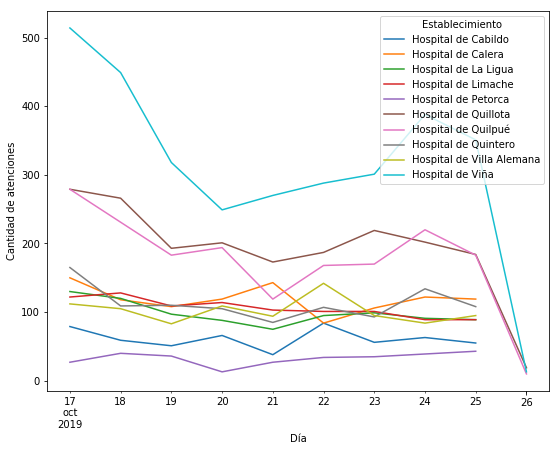

In [131]:
BD.groupby([ BD.TS_ingreso.dt.to_period('D'),'Establecimiento'])['TS_ingreso'].count().unstack().plot(figsize=(9,7))
plt.xlabel('Día')
plt.ylabel('Cantidad de atenciones')
plt.savefig('./producto/atenciones_porhospital.png')

802

Text(0.5, 0, 'Día')

Text(0, 0.5, 'Cantidad de atenciones')

Hospital de Calera           450.0
Hospital de Quilpué          440.0
Hospital de Limache          440.0
Hospital de Villa Alemana    376.7
Hospital de Quillota         276.7
Hospital de Quintero         246.7
Hospital de Viña             200.0
Hospital de La Ligua         136.7
Hospital de Cabildo          100.0
Hospital de Petorca            6.7
Name: Establecimiento, dtype: float64

Leve                53.485425
Sin Lesiones        38.910013
Mediana Gravedad     4.689480
Grave                2.915082
Name: Pronostico, dtype: float64

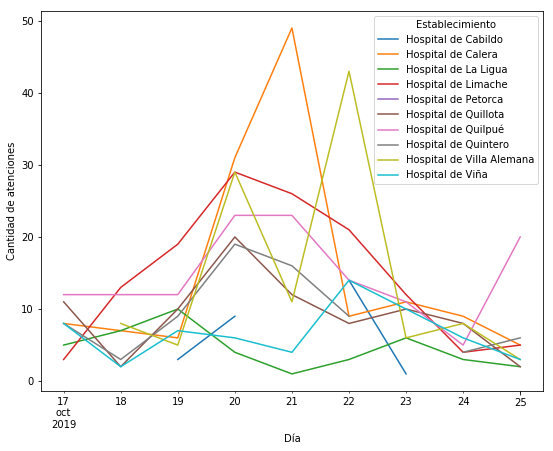

In [135]:
interes = BD[(BD.TipoAccidente.str.contains('Constatar Lesiones') == True) |
          (BD.Arribo == 'Policia') |
          (BD.Destino_paciente == 'Policia')]

interes.Establecimiento.count()

interes.groupby([interes.TS_ingreso.dt.to_period('D'),'Establecimiento'])['TS_ingreso'].count().unstack().plot(figsize=(9,7))
plt.xlabel('Día')
plt.ylabel('Cantidad de atenciones')
plt.savefig('./producto/atenciones_133.png')

round(interes.Establecimiento.value_counts()/tiempo['diferencia'].days*30, 1)
interes.Pronostico.value_counts(normalize=True)*100

In [143]:
interes.Edad.describe()
interes.Sexo_x.value_counts()
interes.Sexo_x.value_counts(normalize=True)*100
interes.Destino_paciente.value_counts(normalize=True)*100


count    802.000000
mean      28.965087
std       13.200132
min        1.000000
25%       20.000000
50%       26.000000
75%       34.000000
max       91.000000
Name: Edad, dtype: float64

Hombre    579
Mujer     223
Name: Sexo_x, dtype: int64

Hombre    72.194514
Mujer     27.805486
Name: Sexo_x, dtype: float64

Policía                   72.370089
Alta domiciliaria         24.081115
Traslado a otro centro     3.295311
Hospitalización            0.253485
Name: Destino_paciente, dtype: float64

In [126]:
dumm.columns

Index(['Establecimiento', 'RutPaciente', 'Edad', 'Sexo_x', 'Comuna',
       'Provincia', 'MotivoConsulta', 'Prevision', 'Telefono', 'Direccion',
       'Nombre', 'Apellido Paterno', 'Apellido Materno', 'Fecha Nacimiento',
       'Plan', 'Condición de Urgencia', 'ClasificacionConsulta',
       'TipoAccidente', 'NumeroAtencionesAnteriores', 'DiagnosticoPrincipal',
       'OtrosDiagnosticos', 'LlegadaEn', 'ProcedenciaPaciente',
       'Origen_paciente', 'Arribo_paciente', 'LlegadaSAMU', 'Destino_paciente',
       'AtInterrumpidaPor', 'AtendidoPor', 'DestinoAlta', 'CondicionAlCierre',
       'Pronostico', 'Categorizacion', 'AtencionEnfermeria', 'Local',
       'TS_ingreso', 'TS_triage', 'TS_atencion', 'TS_cierremedico',
       'TS_egreso', 'DT_EsperaCategorizacion', 'DT_EsperaMD', 'DT_AtencionMD',
       'DT_definicionPAC', 'DT_Espera_CierreAdm', 'DT_Total', 'Triage',
       'Turno', 'Arribo'],
      dtype='object')

Leve                422
Sin Lesiones        307
Mediana Gravedad     37
Grave                23
Name: Pronostico, dtype: int64